<h2> Using ResNet50 on the Food-101 dataset </h2>

<h4>About the Dataset</h4>
<p>data set of 101 food categories, with 101,000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. The Dataset was part of a presentation by Bossard et al. More info <a href="https://www.vision.ee.ethz.ch/datasets_extra/food-101/"> here</a>
    

In [1]:
!curl -s https://course.fast.ai/setup/colab | bash
#command to setup fastai on colab

Updating fastai...
Done.


In [2]:
dest = '/content/data'
url = 'http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz'
! wget -P {dest} {url}
#downloading the data from the url

--2019-10-10 07:56:08--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.162
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2019-10-10 07:56:09--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4.7G) [application/x-gzip]
Saving to: ‘/content/data/food-101.tar.gz’

food-101.tar.gz     100%[===================>]   4.65G  15.0MB/s    in 5m 28s  

2019-10-10 08:01:37 (14.5 MB/s) - ‘/content/data/food-101.tar.gz’ saved [4996278331/4996278331]



### Setting things up
<p> The following few lines of code</p>
<ul><li>untar the tgz file</li>
    <li>create a validation folder</li>
    <li>Read filenames to be used in the test set and move them into the validation folder after doing some work on extracting their name from the data folders</li></ul>

In [ ]:
file = dest + '/food-101.tar.gz'
!cd data && tar xvzf {file}

In [0]:
folder = '/content/data/food-101/valid'
!mkdir {folder}

In [0]:
from pathlib import Path
p = Path('/content/data/food-101/images')
dir_list = [x for x in p.iterdir() if x.is_dir()]

In [0]:
url = '/content/data/food-101/valid/'
for folder in dir_list:
  filename = str(folder).split("/")[-1] 
  foldername = url + filename
  !mkdir {foldername}

In [8]:
import shutil

with open('/content/data/food-101/meta/test.txt','r',encoding='UTF-8') as t:
  url = '/content/data/food-101/'
  for l in t:
    l=l.strip()
    a,b =l.split('/')
    folder = a
    file = str(b+'.jpg')
    src = url + 'images/'+folder+'/'+file
    dest= url+'valid/'+folder+'/'+file
    print(dest)
    shutil.move(src,dest)

/content/data/food-101/valid/apple_pie/1011328.jpg
/content/data/food-101/valid/apple_pie/101251.jpg
/content/data/food-101/valid/apple_pie/1034399.jpg
/content/data/food-101/valid/apple_pie/103801.jpg
/content/data/food-101/valid/apple_pie/1038694.jpg
/content/data/food-101/valid/apple_pie/1047447.jpg
/content/data/food-101/valid/apple_pie/1068632.jpg
/content/data/food-101/valid/apple_pie/110043.jpg
/content/data/food-101/valid/apple_pie/1106961.jpg
/content/data/food-101/valid/apple_pie/1113017.jpg
/content/data/food-101/valid/apple_pie/116705.jpg
/content/data/food-101/valid/apple_pie/1167170.jpg
/content/data/food-101/valid/apple_pie/1174330.jpg
/content/data/food-101/valid/apple_pie/1180600.jpg
/content/data/food-101/valid/apple_pie/1235282.jpg
/content/data/food-101/valid/apple_pie/1269202.jpg
/content/data/food-101/valid/apple_pie/1272958.jpg
/content/data/food-101/valid/apple_pie/1284428.jpg
/content/data/food-101/valid/apple_pie/1295996.jpg
/content/data/food-101/valid/apple_

In [0]:
#renaming images to train
src = '/content/data/food-101/images'
dest = '/content/data/food-101/train'
! mv {src} {dest}

### Train-valid split
<p> I have decided to use the entire dataset for training and the test as validation. This is because I need to have a network with high accuracy which I can then iterate on using different hyperparameters by using a smaller subset(both in classes and image size) to see gains afterwords.<p>
    
<p> So the validation takes place over the actual test set instead of a small segment of the training data</p>

### Note on Framework used
<p>The framework used here is <b>Fastai</b>. Fastai is a wrapper on top of Facebook's PyTorch's Deep Learning framwork created by Jeremy Howard and others. While it is possible to execute this on both Pure PyTorch and Tensorflow, Fastai has the best practices built into it and has great default hyperparamters and higher level abstractions. <p>
<p> The Hyperparameters used are given below</p>

In [0]:
from fastai.vision import *

#### ImageDataBunch 
<p> The imageDataBunch is a fastai abstraction built on top of the PyTorch DataLoader class.It has a default batch size of 64, the ability to resize training images using the "size" attribute </p>
<p>The dataset has been normalized on the ImageNet dataset stats since we'll be using a using a pretrained resnet50 on the ImageNet dataset</p>

In [0]:
path = '/content/data/food-101'
data = ImageDataBunch.from_folder(path,ds_tfms=get_transforms(),size=256).normalize(imagenet_stats)

<p> The get_transforms() functions applies the most reasonable transforms the image dataset .Details <a href="https://docs.fast.ai/vision.transform.html#get_transforms">here</a></p>

In [0]:
#the metrics added include top 5 accuracy and top 1 accuracy
top_5 = partial(top_k_accuracy, k=5)
learn = cnn_learner(data,models.resnet50,metrics=[accuracy,top_5])

##### Learning Rate Finder
Learning rate finder plots lr vs loss relationship for a <b>Learner</b> object in fastai. The idea is to reduce the amount of guesswork on picking a good starting learning rate.

###### Overview:
<ol>
    <li>First run lr_find learn.lr_find()</li>
    <li>Plot the learning rate vs loss learn.recorder.plot()</li>
    <li>Pick a learning rate before it diverges then start training</li>
</ol>

The idea is implemented using Leslie's Smith's paper <a href="https://arxiv.org/abs/1506.01186">here</a> 

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


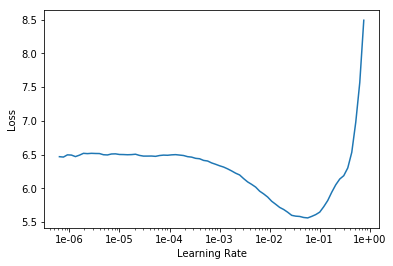

In [0]:
learn.recorder.plot()

From the chart above it is obvious that the rate of decrease of the loss is sharpest when the learning rate is between 5e-3 and 1e-2. 
The model is trained using a cyclical learning rate and with differential learning rates for different layers. The earlier layers have smaller learning rate compared to the later ones.

In [0]:
learn.fit_one_cycle(2,max_lr=slice(5e-3,1e-2))

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.894881,1.421181,0.615129,0.867327,30:59
1,1.279022,0.824410,0.776317,0.944238,30:27


In [0]:
learn.save("stage-1",return_path=True)

PosixPath('/content/data/food-101/models/stage-1.pth')

In [0]:
learn.fit_one_cycle(1,max_lr=slice(5e-3,1e-2))

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.306859,0.826739,0.777465,0.942574,29:13


In [0]:
learn.save("stage-2",return_path=True)

PosixPath('/content/data/food-101/models/stage-2.pth')

In [13]:
learn.load("stage-2")

Learner(data=ImageDataBunch;

Train: LabelList (75750 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
bibimbap,bibimbap,bibimbap,bibimbap,bibimbap
Path: /content/data/food-101;

Valid: LabelList (25250 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
bibimbap,bibimbap,bibimbap,bibimbap,bibimbap
Path: /content/data/food-101;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-0

In [14]:
learn.fit_one_cycle(3,max_lr=slice(5e-3,1e-2))

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.633496,1.217684,0.670059,0.893505,34:02
1,1.333352,0.875454,0.755050,0.938733,33:13
2,1.091406,0.698138,0.804911,0.955366,29:26


In [15]:
learn.save("stage-3",return_path=True)

PosixPath('/content/data/food-101/models/stage-3.pth')

In [16]:
learn.fit_one_cycle(2,max_lr=slice(5e-3,1e-2))

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.495308,1.005488,0.720673,0.922495,31:26
1,1.082624,0.699889,0.806059,0.956000,29:04


In [17]:
learn.save("stage-4",return_path=True)

PosixPath('/content/data/food-101/models/stage-4.pth')

#### Unfreezing the model 
<p> Since we're using a pre-trained model, we need to train all layers of the neural network. </p>

In [0]:
learn.unfreeze()

In [19]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


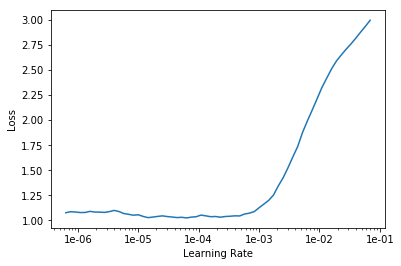

In [20]:
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(4,max_lr=slice(4e-6,9e-4))

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.089283,0.722134,0.797584,0.955525,36:37
1,1.001732,0.645654,0.817505,0.960713,36:15
2,0.828228,0.557949,0.841822,0.968792,36:07
3,0.683484,0.534460,0.850218,0.970218,36:07


In [22]:
learn.save('stage-1-unfreeze',return_path=True)

PosixPath('/content/data/food-101/models/stage-1-unfreeze.pth')

In [23]:
learn.fit_one_cycle(2,max_lr=slice(4e-6,9e-4))

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.807962,0.589192,0.833624,0.965188,36:00
1,0.672916,0.518907,0.853663,0.970297,36:03


In [24]:
learn.save('stage-2-unfreeze',return_path=True)

PosixPath('/content/data/food-101/models/stage-2-unfreeze.pth')

In [25]:
learn.fit_one_cycle(2,max_lr=slice(4e-6,9e-4))

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.775840,0.582212,0.835762,0.966851,36:09
1,0.585588,0.501996,0.857109,0.972158,36:10


In [26]:
learn.save('stage-3-unfreeze',return_path=True)

PosixPath('/content/data/food-101/models/stage-3-unfreeze.pth')

In [42]:
learn.load('stage-3-unfreeze')

Learner(data=ImageDataBunch;

Train: LabelList (75750 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
bibimbap,bibimbap,bibimbap,bibimbap,bibimbap
Path: /content/data/food-101;

Valid: LabelList (25250 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
bibimbap,bibimbap,bibimbap,bibimbap,bibimbap
Path: /content/data/food-101;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-0

In [43]:
learn.fit_one_cycle(2,max_lr=slice(4e-6,9e-4))

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.534691,0.503472,0.857743,0.972594,29:37
1,0.562815,0.500159,0.858851,0.972515,29:22


The accuracy after 9 epochs of post unfreezing training is around 85.88%

since the learning rate is generally the most important hyperparameter for performance, Using Leslie Smith's learning rate finder technique will allow great results to be accomplished incredibly quickly